In [1]:
#/default_exp app

# import

In [2]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook
# ! pip install -Uqq fastbook
# ! pip install -Uqq gradio
# ! pip install -Uqq nbdev
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
#/export
from fastai.vision.all import *
import gradio as gr

# Load dataset

We will use the chest X-ray images labeled 'pneumonia' or 'normal' (no pneumonia) from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia. Clean the dataset by finding null images. 

In [5]:
chest_types = 'normal','pneumonia'
path = Path('chest_xray/train_reduced')

In [6]:
fns = get_image_files(path)
fns

(#1043) [Path('chest_xray/train_reduced/PNEUMONIA/person1439_virus_2453.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person1036_virus_1730.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person806_virus_1439.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person1177_virus_1999.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person28_bacteria_142.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person1034_virus_1728.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person557_virus_1097.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person41_bacteria_207.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person1341_virus_2313.jpeg'),Path('chest_xray/train_reduced/PNEUMONIA/person895_virus_1547.jpeg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

# Create a dataloader

Important to note that we set 20% of the data for the validation set, and resize each image to 128x128. 

In [9]:
chests = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = chests.dataloaders(path)

We want all the images to be the same size. We can explore some options: 

1. Stretch or shrink the image to fit the size. However, this would have the model learn that the images are different, and we can expect a lower accuracy. 
2. Pad the images. This would lead wasted compute, and a lower effective resolution to the actual image. 
3. Crop the image. We might crop out a key part of the image. 

We use a solution:

- crop the image, but randomly crop a part of the original image each epoch. The model can learn different parts of the image that way. 

In [11]:
chests = chests.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = chests.dataloaders(path)

# Training

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/home/tony/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tony/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.932991,1.310391,0.403846,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.665416,0.504830,0.182692,01:29
1,0.512723,0.795649,0.235577,01:33
2,0.430458,0.295846,0.076923,01:27
3,0.345208,0.401481,0.076923,01:26
4,0.308788,0.358354,0.057692,01:35
5,0.258811,0.302653,0.057692,01:26


# Analysis

We can see that we have an error of ~5%, not bad! Further, we can see our confusion matrix and our top losses to do further analysis. 

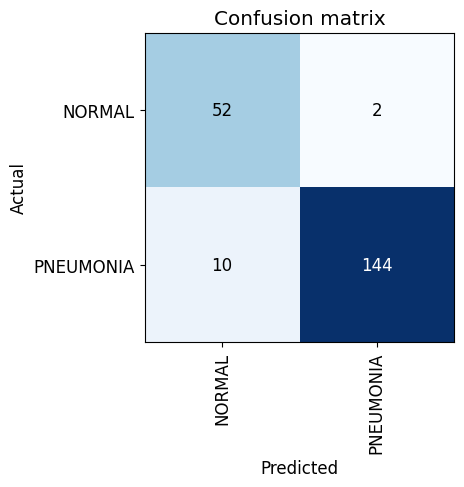

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

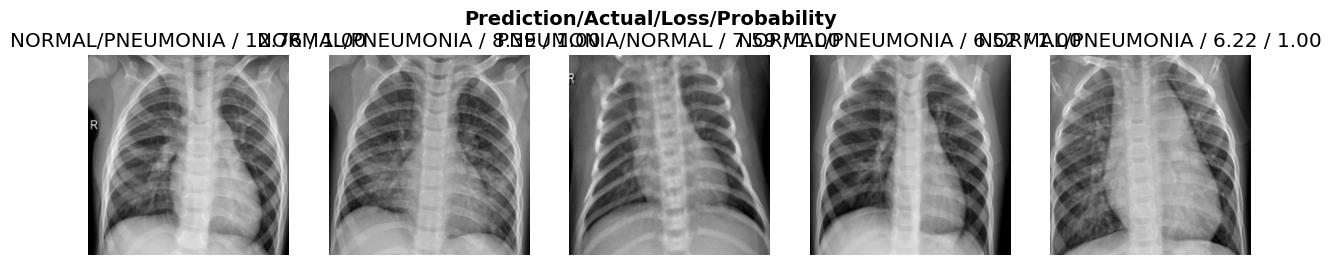

In [14]:
interp.plot_top_losses(5, nrows=1)

# Data processing (again)

In [15]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [17]:
learn.export('chestXray_reduced.pkl')

# Create an interface using Gradio

This section of the notebook can be used on its own, assuming that a .pkl model was already trained. We can simply load it, and create the interface from there. 

In [4]:
learn = load_learner('chestXray.pkl')

In [5]:
learn.predict('chest_xray/test/NORMAL/IM-0007-0001.jpeg')

('NORMAL', tensor(0), tensor([0.9718, 0.0282]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [20]:
learn.dls.vocab

['NORMAL', 'PNEUMONIA']

In [7]:
#/export
categories = ('No Pneumonia', 'Pneumonia')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [45]:
classify_image('chest_xray/test/NORMAL/IM-0007-0001.jpeg')

{'No Pneumonia': 0.9718326926231384, 'Pneumonia': 0.028167350217700005}

In [8]:
#/export 
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
path = '02_projectimages/'
examples = [f'{path}Pneumonia 1.jpeg', f'{path}Pneumonia 2.jpeg', f'{path}Pneumonia 3.jpeg', f'{path}No Pneumonia 1.jpeg', f'{path}No Pneumonia 2.jpeg', f'{path}No Pneumonia 3.jpeg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/tmp/ipykernel_24962/2107893260.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(192,192))
/tmp/ipykernel_24962/2107893260.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(192,192))
/tmp/ipykernel_24962/2107893260.py:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
/tmp/ipykernel_24962/2107893260.py:3: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# export

Export to a python file to be intergrated into an app on its own. 

In [12]:
import nbdev
import os

notebook_name = 'app.ipynb'
export_dir = './'

# Export the notebook
nbdev.export.nb_export(notebook_name, export_dir)